# Exploring the New York City Taxi Data with Arkouda + Pandas/NumPy

This notebook shows some examples of how to interoperate between Pandas and Arkouda at a small scale on a few-GB workstation. This same notebook would run with a multi-node Arkouda instance on an HPC with TB of data.

Arkouda is not trying to replace Pandas but to allow for some Pandas-style operation at a much larger scale. In our experience Pandas can handle dataframes up to about **500 million rows** on a sufficently capable compute server before performance becomes a real issue. Arkouda breaks the shared memory paradigm and scales its operations to distributed dataframes with **hundreds of billions of rows**, maybe even a trillion. In practice we have run Arkouda server operations on columns of one trillion elements running on 512 compute nodes. This yielded a **>20TB dataframe** in Arkouda.

**Outline**
- Data Preparation
  - Get Data
  - Convert Data
  - Load Data
- Data Exploration
  - Summarization
  - Histograms
  - Logical Indexing/Filtering
  - Time Data
  - Lookup Tables
  - GroupBy-Aggregate
  - Broadcast
  - Integrate with Pandas

# Data Preparation

## Download New York City Taxi Data
----------------------------------
[Yellow Trips Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

[NYC Yellow Taxi Trip Records Jan 2020](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv)

[Green Trips Data Dictionary](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

[NYC Green  Taxi Trip Records Jan 2020](https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2020-01.csv)

[NYC Taxi Zone Lookup Table](https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv)

[NYC Taxi Zone Shapefile](https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip)

## Convert and Load Data

2 methods:
* Load in python (e.g. with pandas) and transfer to arkouda
  * Good for prototyping with small data
* Convert to HDF5 (in separate process) and read directly with arkouda
  * Best for large datasets
  
#### Dtypes Supported in HDF5
Arkouda can only read these HDF5 dtypes
* int (any width) -> int64
* float (any width) -> float64
* custom string format -> ak.Strings

#### Additional Dtypes in Arkouda
Can cast/convert to these after loading raw data
* bool
* Datetime (from int64)
* Timedelta (from int64)

#### Prefer Integers!
They are fast and versatile (usable with GroupBy, Datetime, Timedelta, bit ops, etc.)

### Describe Data Format

In [1]:
!head /home/reusters/data/yellow_tripdata_2020-01.csv

In [2]:
%%file NYCTaxi_format.py

import numpy as np

OPTIONS = {}

def YNint(yn):
    return (0, 1)[yn.upper() in 'YES']

def nullint(x):
    try:
        return np.int64(x)
    except:
        return np.int64(-1)

yellow_format = {'sep': ',',
                 'header': 0,
                 'parse_dates':['tpep_dropoff_datetime', 'tpep_pickup_datetime'],
                 'infer_datetime_format': True,
                 'converters': {'store_and_fwd_flag': YNint,
                                'VendorID': nullint,
                                'RatecodeID': nullint,
                                'PULocationID': nullint,
                                'DOLocationID': nullint,
                                'passenger_count': nullint,
                                'payment_type': nullint,
                                'trip_type': nullint}}

OPTIONS['yellow'] = yellow_format

green_format = yellow_format.copy()
green_format['parse_dates'] = ['lpep_dropoff_datetime', 'lpep_pickup_datetime']
OPTIONS['green'] = green_format

Overwriting NYCTaxi_format.py


### Conversion Method 1: CSV --> Pandas --> Arkouda (NOT SHOWN HERE)

See ./NYCTaxi_small.ipynb

### Conversion Method 2: CSV --> HDF5 --> Arkouda

Arkouda comes with a CSV to HDF5 converter in the repo. It uses the NYCTaxi_format.py file we defined above.

#### Convert to HDF5

In [3]:
!python3 /home/reusters/arkouda/converter/csv2hdf.py \
--formats-file=/home/reusters/ArkoudaNotebooks/NYCTaxi_format.py \
--format=yellow \
--outdir=/home/reusters/data/ \
/home/reusters/data/yellow_tripdata_2020-01.csv

Columns to be extracted:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               1000 non-null   int64         
 1   tpep_pickup_datetime   1000 non-null   datetime64[ns]
 2   tpep_dropoff_datetime  1000 non-null   datetime64[ns]
 3   passenger_count        1000 non-null   int64         
 4   trip_distance          1000 non-null   float64       
 5   RatecodeID             1000 non-null   int64         
 6   store_and_fwd_flag     1000 non-null   int64         
 7   PULocationID           1000 non-null   int64         
 8   DOLocationID           1000 non-null   int64         
 9   payment_type           1000 non-null   int64         
 10  fare_amount            1000 non-null   float64       
 11  extra                  1000 non-null   float64       
 12  mta_tax                1000 non-null  

#### Read into Arkouda

In [5]:
# Can skip this if already connected above
import arkouda as ak
ak.connect(connect_url="tcp://localhost:5555")

connected to arkouda server tcp://*:5555


In [6]:
data = ak.read_all('/home/reusters/data/yellow_tripdata_2020-01.hdf')

### Optional: Convert Columns to Specialized Dtypes

In [7]:
data['tpep_pickup_datetime'] = ak.Datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = ak.Datetime(data['tpep_dropoff_datetime'])
data['store_and_fwd_flag'] = (data['store_and_fwd_flag'] == 1)

In [8]:
data

{'DOLocationID': array([239, 238, 238, ..., 169, 42, 205]),
 'PULocationID': array([238, 239, 238, ..., 137, 50, 179]),
 'RatecodeID': array([1, 1, 1, ..., -1, -1, -1]),
 'VendorID': array([1, 1, 1, ..., -1, -1, -1]),
 'congestion_surcharge': array([2.5, 2.5, 2.5, ..., 0, 0, 0]),
 'extra': array([3, 3, 3, ..., 2.75, 2.75, 2.75]),
 'fare_amount': array([6, 7, 6, ..., 48.850000000000001, 27.170000000000002, 54.560000000000002]),
 'improvement_surcharge': array([0.29999999999999999, 0.29999999999999999, 0.29999999999999999, ..., 0.29999999999999999, 0.29999999999999999, 0.29999999999999999]),
 'mta_tax': array([0.5, 0.5, 0.5, ..., 0, 0, 0.5]),
 'passenger_count': array([1, 1, 1, ..., -1, -1, -1]),
 'payment_type': array([1, 1, 1, ..., -1, -1, -1]),
 'store_and_fwd_flag': array([False, False, False, ..., True, True, True]),
 'tip_amount': array([1.47, 1.5, 1, ..., 0, 0, 0]),
 'tolls_amount': array([0, 0, 0, ..., 0, 0, 0]),
 'total_amount': array([11.27, 12.300000000000001, 10.8000000000000

In [9]:
rows = data['VendorID'].size
numbytes = sum(v.size*v.itemsize for v in data.values())

In [10]:
print(f'{rows:,} rows\n{numbytes:,} bytes')

6,405,008 rows
877,486,096 bytes


# Data Exploration

## Descriptive Statistics

In [11]:
def describe(x):
    fmt = 'mean: {}\nstd : {}\nmin : {}\nmax : {}'
    if x.dtype == ak.float64:
        fmt = fmt.format(*['{:.2f}' for _ in range(4)])
    print(fmt.format(x.mean(), x.std(), x.min(), x.max()))

In [12]:
describe(data['fare_amount'])

mean: 12.69
std : 12.13
min : -1238.00
max : 4265.00


## Histograms

In [13]:
import numpy as np
from matplotlib import pyplot as plt

def hist(x, bins, log=True):
    assert bins > 0
    # Compute histogram counts in arkouda
    h = ak.histogram(x, bins)
    # Compute bins in numpy
    if isinstance(x, ak.Datetime):
        # Matplotlib has trouble plotting np.datetime64 and np.timedelta64
        bins = ak.date_range(x.min(), x.max(), periods=bins).to_ndarray().astype('int')
    elif isinstance(x, ak.Timedelta):
        bins = ak.timedelta_range(x.min(), x.max(), periods=bins).to_ndarray().astype('int')
    else:
        bins = np.linspace(x.min(), x.max(), bins+1)[:-1]
    # Bring h over to numpy for plotting
    plt.bar(bins, h.to_ndarray(), width=bins[1]-bins[0])
    if log:
        plt.yscale('log')

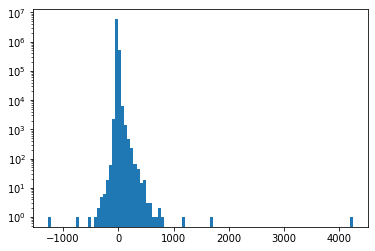

In [14]:
hist(data['fare_amount'], 100)

## Logical Indexing (Filters)
Find non-negative fares

In [15]:
nonneg = data['fare_amount'] >= 0
print(f'{nonneg.sum() / nonneg.size :.1%} of fares are non-negative')

99.7% of fares are non-negative


Select only non-negative fares for computation

In [16]:
describe(data['fare_amount'][nonneg])

mean: 12.77
std : 12.01
min : 0.00
max : 4265.00


Make new data dict with only non-negative fares

In [17]:
data_nonneg = {k:v[nonneg] for k, v in data.items()}

In [18]:
data_nonneg

{'DOLocationID': array([239, 238, 238, ..., 169, 42, 205]),
 'PULocationID': array([238, 239, 238, ..., 137, 50, 179]),
 'RatecodeID': array([1, 1, 1, ..., -1, -1, -1]),
 'VendorID': array([1, 1, 1, ..., -1, -1, -1]),
 'congestion_surcharge': array([2.5, 2.5, 2.5, ..., 0, 0, 0]),
 'extra': array([3, 3, 3, ..., 2.75, 2.75, 2.75]),
 'fare_amount': array([6, 7, 6, ..., 48.850000000000001, 27.170000000000002, 54.560000000000002]),
 'improvement_surcharge': array([0.29999999999999999, 0.29999999999999999, 0.29999999999999999, ..., 0.29999999999999999, 0.29999999999999999, 0.29999999999999999]),
 'mta_tax': array([0.5, 0.5, 0.5, ..., 0, 0, 0.5]),
 'passenger_count': array([1, 1, 1, ..., -1, -1, -1]),
 'payment_type': array([1, 1, 1, ..., -1, -1, -1]),
 'store_and_fwd_flag': array([False, False, False, ..., True, True, True]),
 'tip_amount': array([1.47, 1.5, 1, ..., 0, 0, 0]),
 'tolls_amount': array([0, 0, 0, ..., 0, 0, 0]),
 'total_amount': array([11.27, 12.300000000000001, 10.8000000000000

## Time Data

In [19]:
data['ride_duration'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']

In [20]:
data['ride_duration']

Timedelta(['0 days 00:04:48',
           '0 days 00:07:25',
           '0 days 00:06:11',
           ... ,
           '0 days 00:27:50',
           '0 days 00:22:39',
           '0 days 00:22:00'],
          dtype='timedelta64[ns]')

In [21]:
data['ride_duration'].min(), data['ride_duration'].max()

(Timedelta('-2 days +01:49:38'), Timedelta('5 days 22:05:07'))

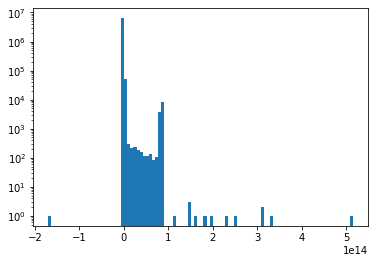

In [22]:
hist(data['ride_duration'], 100)

## Taxi Zone Lookup Table

### Use Method 1: CSV --> Pandas --> Arkouda

In [23]:
import pandas as pd

def cvt_to_string(v):
    try:
        if v == '':
            return 'N/A'
        else:
            return str(v)
    except:
        return 'N/A'

# read the taxi-zone-lookup-table
cvt = {'Borough':cvt_to_string, 'Zone':cvt_to_string, 'service_zone':cvt_to_string}
tzlut = pd.read_csv("/home/reusters/data/taxi+_zone_lookup.csv",converters=cvt)

# location id is 1-based, index is 0-based
# fix it up to be aligned with index in data frame
# which means add row zero
top_row = pd.DataFrame({'LocationID': [0], 'Borough': ['N/A'], 'Zone': ['N/A'], 'service_zone': ['N/A']})
tzlut = pd.concat([top_row, tzlut]).reset_index(drop = True)

In [24]:
tzlut

,LocationID,Borough,Zone,service_zone
0,0,N/A,N/A,N/A
1,1,EWR,Newark Airport,EWR
2,2,Queens,Jamaica Bay,Boro Zone
3,3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,4,Manhattan,Alphabet City,Yellow Zone
...,...,...,...,...
261,261,Manhattan,World Trade Center,Yellow Zone
262,262,Manhattan,Yorkville East,Yellow Zone
263,263,Manhattan,Yorkville West,Yellow Zone
264,264,Unknown,NV,N/A


### Convert dataframe to dictionary of Arkouda arrays

In [25]:
# transfer columns of DataFrame to arkouda
def ak_create_akdict_from_df(df):
    akdict = {}
    for cname in df.keys():
        if df[cname].dtype.name == 'object':
            akdict[cname] = ak.from_series(df[cname],dtype=np.str)
        else:
            akdict[cname] = ak.from_series(df[cname])

    return akdict

In [26]:
# convert data frame with strings and int64 data
aktzlut = ak_create_akdict_from_df(tzlut)

In [27]:
aktzlut

{'LocationID': array([0, 1, 2, ..., 263, 264, 265]),
 'Borough': array(['N/A', 'EWR', 'Queens', ... , 'Manhattan', 'Unknown', 'Unknown']),
 'Zone': array(['N/A', 'Newark Airport', 'Jamaica Bay', ... , 'Yorkville West', 'NV', 'NA']),
 'service_zone': array(['N/A', 'EWR', 'Boro Zone', ... , 'Yellow Zone', 'N/A', 'N/A'])}

### Apply Lookup Table

Ensure LocationID is really a dense, 0-up index

In [28]:
(aktzlut['LocationID'] == ak.arange(aktzlut['LocationID'].size)).all()

True

In [29]:
data['PUBorough'] = aktzlut['Borough'][data['PULocationID']]
data['DOBorough'] = aktzlut['Borough'][data['DOLocationID']]

In [30]:
data['PUZone'] = aktzlut['Zone'][data['PULocationID']]
data['DOZone'] = aktzlut['Zone'][data['DOLocationID']]

In [31]:
data

{'DOLocationID': array([239, 238, 238, ..., 169, 42, 205]),
 'PULocationID': array([238, 239, 238, ..., 137, 50, 179]),
 'RatecodeID': array([1, 1, 1, ..., -1, -1, -1]),
 'VendorID': array([1, 1, 1, ..., -1, -1, -1]),
 'congestion_surcharge': array([2.5, 2.5, 2.5, ..., 0, 0, 0]),
 'extra': array([3, 3, 3, ..., 2.75, 2.75, 2.75]),
 'fare_amount': array([6, 7, 6, ..., 48.850000000000001, 27.170000000000002, 54.560000000000002]),
 'improvement_surcharge': array([0.29999999999999999, 0.29999999999999999, 0.29999999999999999, ..., 0.29999999999999999, 0.29999999999999999, 0.29999999999999999]),
 'mta_tax': array([0.5, 0.5, 0.5, ..., 0, 0, 0.5]),
 'passenger_count': array([1, 1, 1, ..., -1, -1, -1]),
 'payment_type': array([1, 1, 1, ..., -1, -1, -1]),
 'store_and_fwd_flag': array([False, False, False, ..., True, True, True]),
 'tip_amount': array([1.47, 1.5, 1, ..., 0, 0, 0]),
 'tolls_amount': array([0, 0, 0, ..., 0, 0, 0]),
 'total_amount': array([11.27, 12.300000000000001, 10.8000000000000

## GroupBy: Construct a Graph

Directed graph from PULocationID --> DOLocationID

In [32]:
byloc = ak.GroupBy([data['PULocationID'], data['DOLocationID']])

In [33]:
byloc.unique_keys

[array([1, 1, 1, ..., 265, 265, 265]), array([1, 50, 68, ..., 263, 264, 265])]

Edge weight is number of rides

Aggregation methods of `GroupBy` return tuple of (unique_keys, aggregate_values)

In [34]:
(u, v), w = byloc.count()

In [35]:
u, v, w

(array([1, 1, 1, ..., 265, 265, 265]),
 array([1, 50, 68, ..., 263, 264, 265]),
 array([638, 1, 1, ..., 4, 317, 2508]))

## Broadcast: Find Rides with Anomalous Fares

Compute mean and std of fare by (pickup, dropoff)

In [36]:
_, mf = byloc.mean(data['fare_amount'])

In [37]:
sf = (byloc.sum(data['fare_amount']**2)[1] / w) - mf**2

Broadcast group values back to ride dataframe to compute z-scores of rides

In [38]:
data['fare_mean'] = byloc.broadcast(mf, permute=True)
data['fare_std'] = byloc.broadcast(sf, permute=True)

In [39]:
data['fare_z'] = (data['fare_amount'] - data['fare_mean']) / (data['fare_std'] + 1)

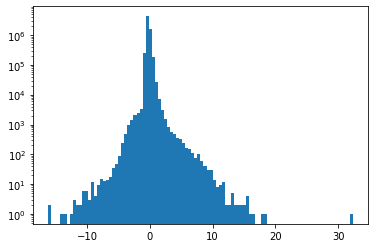

In [40]:
hist(data['fare_z'], 100)

## Bring Small Result Set Back to Pandas

In [41]:
exorbitant = (data['fare_z'] > 15)
exdf = pd.DataFrame({k: v[exorbitant].to_ndarray() for k, v in data.items()})

In [43]:
exdf.head(5)

,DOLocationID,PULocationID,RatecodeID,VendorID,congestion_surcharge,extra,fare_amount,improvement_surcharge,mta_tax,passenger_count,...,tpep_pickup_datetime,trip_distance,ride_duration,PUBorough,DOBorough,PUZone,DOZone,fare_mean,fare_std,fare_z
0,239,142,1,1,2.5,2.5,73.5,0.3,0.5,2,...,2020-01-02 10:33:32,14.60,0 days 02:00:23,Manhattan,Manhattan,Lincoln Square East,Upper West Side South,5.967514,3.295863,15.720352
1,237,141,5,2,2.5,0.0,200.0,0.3,0.0,1,...,2020-01-04 04:40:25,0.11,0 days 00:01:21,Manhattan,Manhattan,Lenox Hill West,Upper East Side South,5.635080,10.946301,16.269883
2,90,249,5,2,2.5,0.0,93.0,0.0,0.0,1,...,2020-01-07 10:02:11,1.20,0 days 03:41:06,Manhattan,Manhattan,West Village,Flatiron,5.511267,4.614001,15.584024
3,236,236,5,1,0.0,0.0,500.0,0.3,0.0,1,...,2020-01-09 11:30:33,2.50,0 days 00:00:44,Manhattan,Manhattan,Upper East Side North,Upper East Side North,5.229094,31.379864,15.280203
4,238,239,5,2,2.5,0.0,200.0,0.3,0.0,1,...,2020-01-16 04:21:37,0.75,0 days 00:13:51,Manhattan,Manhattan,Upper West Side South,Upper West Side North,5.374298,4.976883,32.563077


In [44]:
worst = data['fare_z'].argmax()
{k:v[worst] for k, v in data.items()}

{'DOLocationID': 238,
 'PULocationID': 239,
 'RatecodeID': 5,
 'VendorID': 2,
 'congestion_surcharge': 2.5,
 'extra': 0.0,
 'fare_amount': 200.0,
 'improvement_surcharge': 0.3,
 'mta_tax': 0.0,
 'passenger_count': 1,
 'payment_type': 2,
 'store_and_fwd_flag': False,
 'tip_amount': 0.0,
 'tolls_amount': 0.0,
 'total_amount': 202.8,
 'tpep_dropoff_datetime': Timestamp('2020-01-16 04:35:28'),
 'tpep_pickup_datetime': Timestamp('2020-01-16 04:21:37'),
 'trip_distance': 0.75,
 'ride_duration': Timedelta('0 days 00:13:51'),
 'PUBorough': 'Manhattan',
 'DOBorough': 'Manhattan',
 'PUZone': 'Upper West Side South',
 'DOZone': 'Upper West Side North',
 'fare_mean': 5.374297533092999,
 'fare_std': 4.976883060492071,
 'fare_z': 32.56307685746886}

## Disconnect from the server or shutdown the server

In [49]:
# disconnect or shutdown the server
#ak.disconnect()
#ak.shutdown()